In [2]:
from google.colab import drive
drive.mount('/content/drive')

ValueError: mount failed

In [3]:
import os
import gc
import re

import cv2
import math
import numpy as np
import scipy as sp
import pandas as pd

import tensorflow as tf
from keras.utils import plot_model
import tensorflow.keras.layers as L
from keras.utils import model_to_dot
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

tqdm.pandas()
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
np.random.seed(0)
tf.random.set_seed(0)

import warnings
warnings.filterwarnings("ignore")


In [4]:
Path_train = '/content/drive/MyDrive/project1_genAI/data/train'
Path_val = '/content/drive/MyDrive/project1_genAI/data/val'

 **Visualizing The Data**



**Data train**

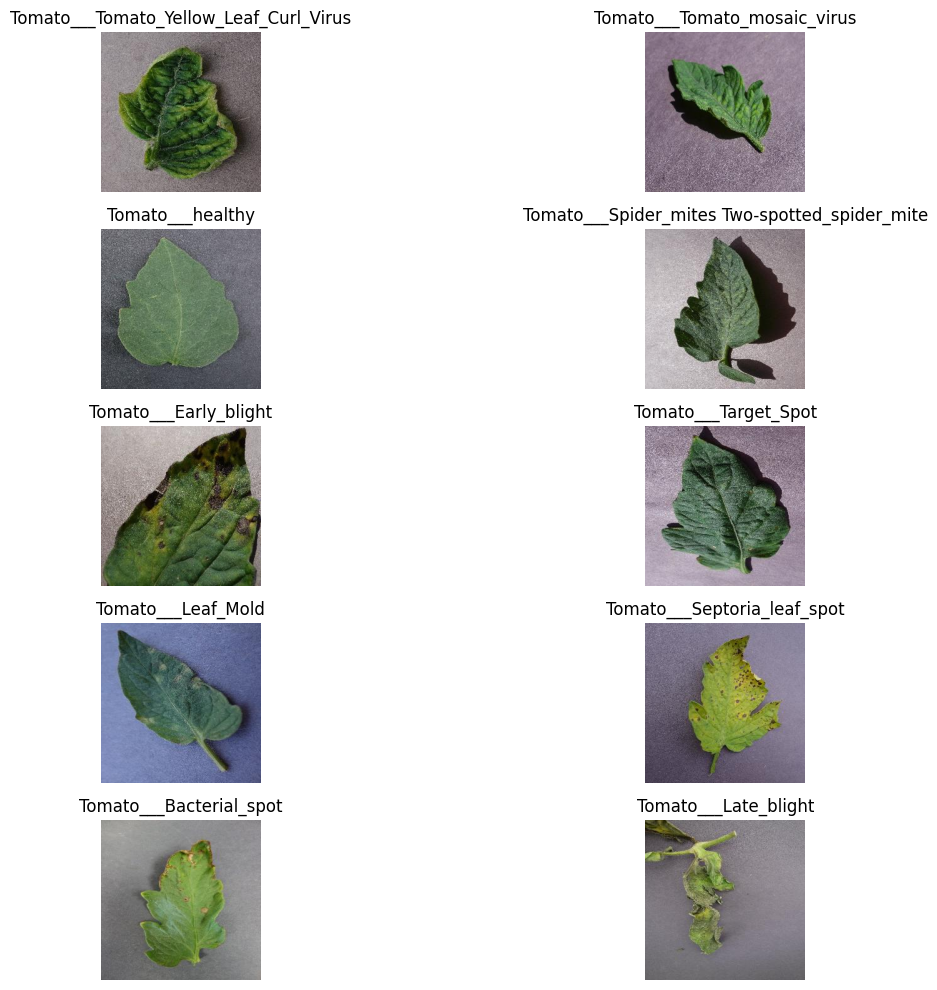

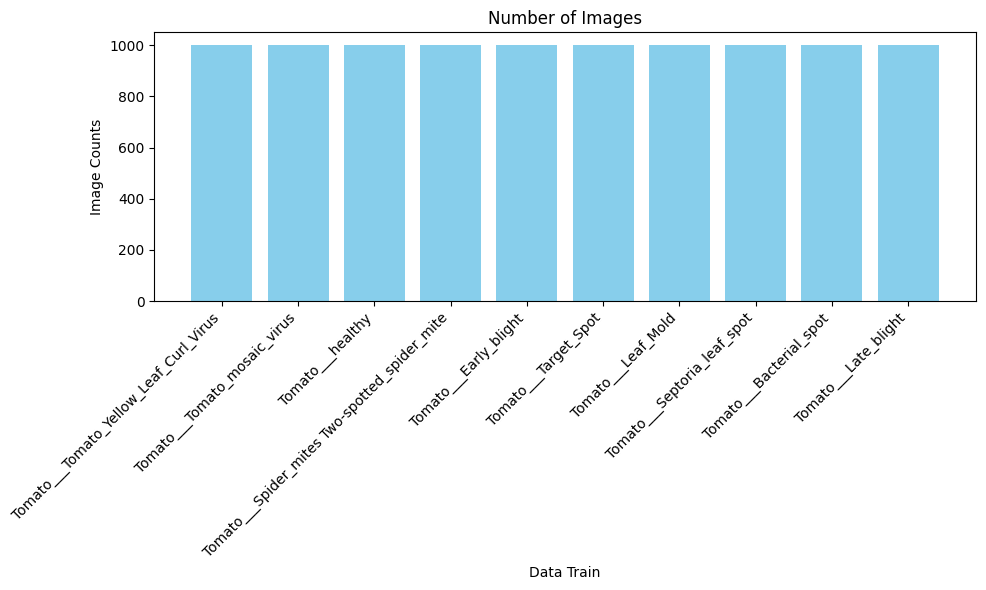

In [5]:
folders = [f for f in os.listdir(Path_train) if os.path.isdir(os.path.join(Path_train, f))]
# Thiết lập kích thước hiển thị cho các ảnh
plt.figure(figsize=(15, 10))

dict_count = {}
# Duyệt qua từng folder và lấy ảnh đầu tiên
for idx, folder_name in enumerate(folders):
    folder_path = os.path.join(Path_train, folder_name)

    # Lấy danh sách các ảnh trong thư mục
    images = os.listdir(folder_path)
    dict_count[folder_name] = len(images)
    if images:  # Kiểm tra nếu thư mục không rỗng
        # Đường dẫn đến ảnh đầu tiên
        img_path = os.path.join(folder_path, images[0])

        # Đọc ảnh bằng OpenCV
        img = cv2.imread(img_path)

        # Chuyển từ BGR sang RGB để hiển thị đúng màu trong matplotlib
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Hiển thị ảnh
        plt.subplot(5, 2, idx + 1)  # Chỉnh số hàng và cột phù hợp với số ảnh
        plt.imshow(img_rgb)
        plt.title(folder_name)  # Gắn nhãn bằng tên thư mục
        plt.axis('off')  # Tắt hiển thị trục

plt.tight_layout()
plt.show()

# Vẽ biểu đồ cột từ dict_count
plt.figure(figsize=(10, 6))
plt.bar(dict_count.keys(), dict_count.values(), color='skyblue')
plt.xlabel("Data Train")
plt.ylabel("Image Counts")
plt.title("Number of Images")
plt.xticks(rotation=45, ha="right")  # Xoay nhãn trục x để dễ đọc
plt.tight_layout()
plt.show()


**Data Val**

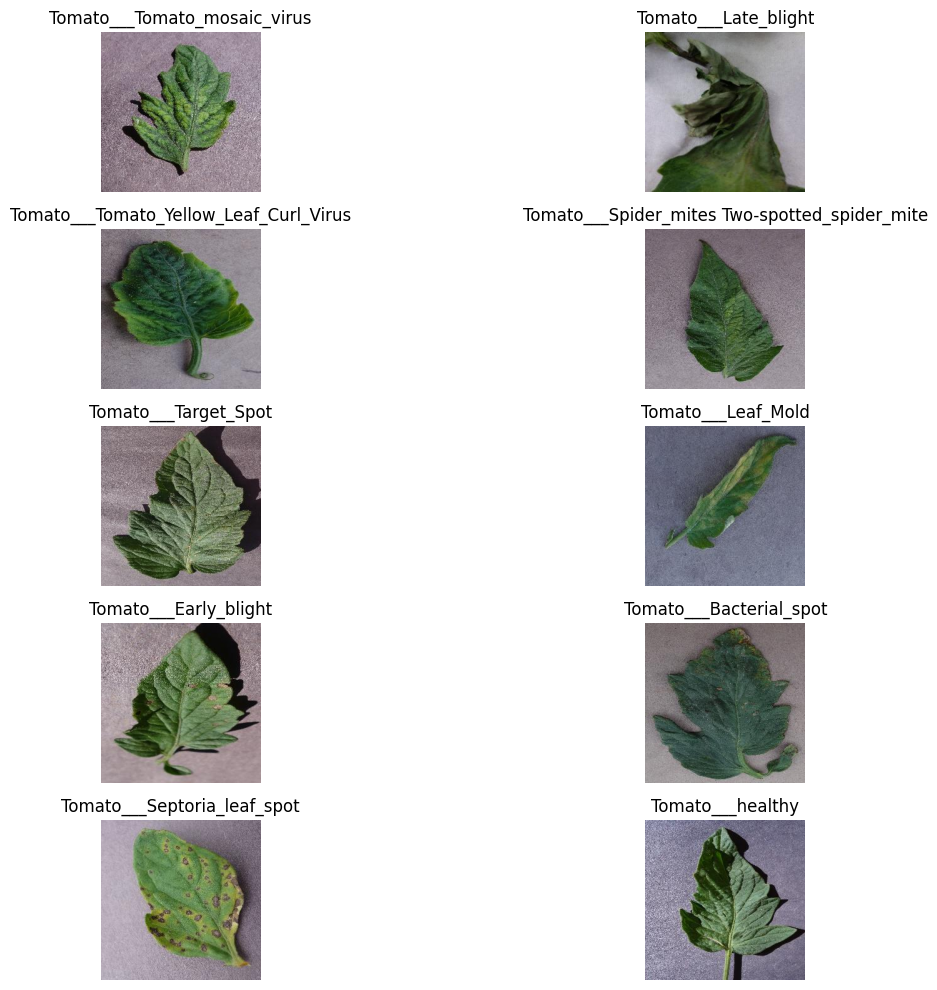

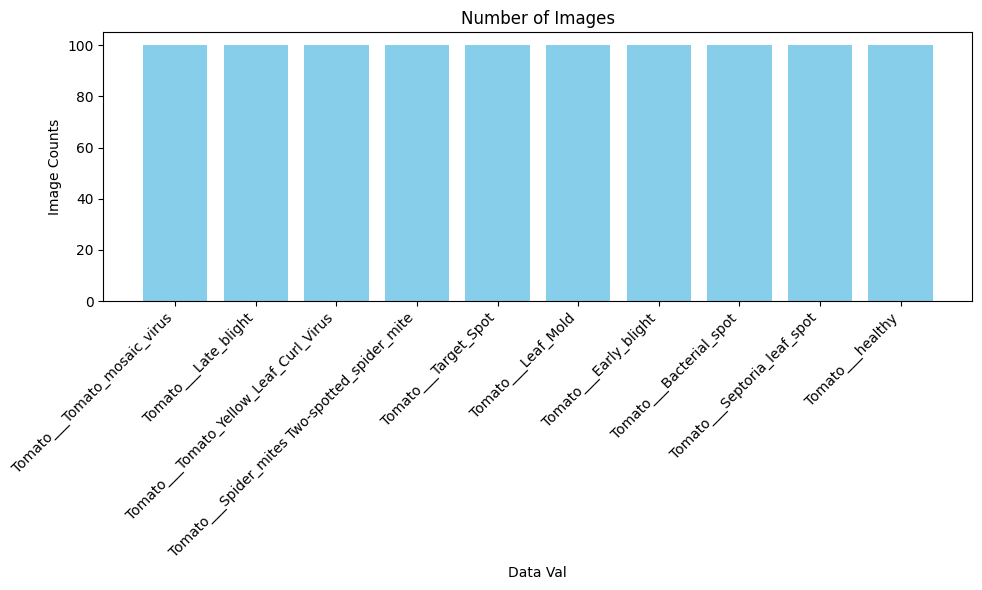

In [6]:
folders = [f for f in os.listdir(Path_val) if os.path.isdir(os.path.join(Path_val, f))]
# Thiết lập kích thước hiển thị cho các ảnh
plt.figure(figsize=(15, 10))

dict_count = {}
# Duyệt qua từng folder và lấy ảnh đầu tiên
for idx, folder_name in enumerate(folders):
    folder_path = os.path.join(Path_val, folder_name)

    # Lấy danh sách các ảnh trong thư mục
    images = os.listdir(folder_path)
    dict_count[folder_name] = len(images)
    if images:  # Kiểm tra nếu thư mục không rỗng
        # Đường dẫn đến ảnh đầu tiên
        img_path = os.path.join(folder_path, images[0])

        # Đọc ảnh bằng OpenCV
        img = cv2.imread(img_path)

        # Chuyển từ BGR sang RGB để hiển thị đúng màu trong matplotlib
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Hiển thị ảnh
        plt.subplot(5, 2, idx + 1)  # Chỉnh số hàng và cột phù hợp với số ảnh
        plt.imshow(img_rgb)
        plt.title(folder_name)  # Gắn nhãn bằng tên thư mục
        plt.axis('off')  # Tắt hiển thị trục

plt.tight_layout()
plt.show()

# Vẽ biểu đồ cột từ dict_count
plt.figure(figsize=(10, 6))
plt.bar(dict_count.keys(), dict_count.values(), color='skyblue')
plt.xlabel("Data Val")
plt.ylabel("Image Counts")
plt.title("Number of Images")
plt.xticks(rotation=45, ha="right")  # Xoay nhãn trục x để dễ đọc
plt.tight_layout()
plt.show()


**Create data_train, data_val**

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Tạo ImageDataGenerator với các kỹ thuật tăng cường dữ liệu
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
img_size=256

In [7]:
# train_data = datagen.flow_from_directory(
#     directory=Path_train,
#     target_size=(img_size, img_size),
#     class_mode='categorical',
#     batch_size=32,
# )

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=Path_train,
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32)

train_data = train_data.map(lambda x, y: (x / 255.0, y))


Found 10000 files belonging to 10 classes.


In [9]:
# val_data = datagen.flow_from_directory(
#     directory=Path_val,
#     class_mode='categorical',
#     batch_size=32,
#     target_size=(img_size, img_size)
# )
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory=Path_val,
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32)

val_data = val_data.map(lambda x, y: (x / 255.0, y))


Found 1000 files belonging to 10 classes.


**Define model**

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.applications import DenseNet121


conv_base = DenseNet121(
    weights='imagenet',
    include_top = False,
    input_shape=(256,256,3),
    pooling='avg'
)
conv_base.trainable = False
model = Sequential()
model.add(conv_base)
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.35))
model.add(BatchNormalization())
model.add(Dense(120, activation='relu'))
model.add(Dense(10, activation='softmax'))



29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


**Train**

In [11]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy']
              )

In [12]:
import matplotlib.pyplot as plt

class RealTimePlotCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.epochs = []
        self.history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}

    def on_epoch_end(self, epoch, logs=None):
        self.epochs.append(epoch + 1)
        for key in self.history.keys():
            self.history[key].append(logs[key])

        # Vẽ đồ thị
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(self.epochs, self.history['loss'], label="Training Loss", color='blue')
        plt.plot(self.epochs, self.history['val_loss'], label="Validation Loss", color='orange')
        plt.title("Loss over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.epochs, self.history['accuracy'], label="Training Accuracy", color='green')
        plt.plot(self.epochs, self.history['val_accuracy'], label="Validation Accuracy", color='red')
        plt.title("Accuracy over Epochs")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()

        plt.tight_layout()
        plt.show()


In [13]:
from tensorflow.keras.callbacks import Callback ,ReduceLROnPlateau,Callback, ModelCheckpoint, EarlyStopping

class KeepLastNCheckpoints(Callback):
    def __init__(self, filepath, n_keep=3):
        super().__init__()
        self.filepath = filepath
        self.n_keep = n_keep  # Số lượng checkpoint muốn giữ

    def on_epoch_end(self, epoch, logs=None):
        # Lấy danh sách các file checkpoint
        checkpoints = sorted(
            [f for f in os.listdir(os.path.dirname(self.filepath)) if f.startswith("ckpt")],
            key=lambda x: os.path.getmtime(os.path.join(os.path.dirname(self.filepath), x))
        )

        # Nếu vượt quá số lượng cần giữ, xóa file cũ nhất
        if len(checkpoints) > self.n_keep:
            os.remove(os.path.join(os.path.dirname(self.filepath), checkpoints[0]))

# Đường dẫn lưu checkpoint
checkpoint_dir = "/content/drive/MyDrive/project1_genAI/checkpoint"
os.makedirs(checkpoint_dir, exist_ok=True)

# Callback ModelCheckpoint
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "ckpt_epoch_{epoch:02d}.weights.h5"),
    save_weights_only=False,  # Chỉ lưu trọng số
    save_best_only=False,    # Lưu tất cả các epoch
    verbose=1
)



In [18]:


early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.000001,
                                         verbose=1)
realtime_plot = RealTimePlotCallback()

# Callback để xóa checkpoint cũ
cleanup_callback = KeepLastNCheckpoints(
    filepath=os.path.join(checkpoint_dir, "ckpt_epoch_{epoch:02d}.h5"),
    n_keep=3
)

callbacks = [reduce_learning_rate, realtime_plot, checkpoint_callback, cleanup_callback]

In [ ]:
history = model.fit(train_data, epochs=38,validation_data=val_data,verbose=1,callbacks=callbacks,shuffle=True)

Output hidden; open in https://colab.research.google.com to view.

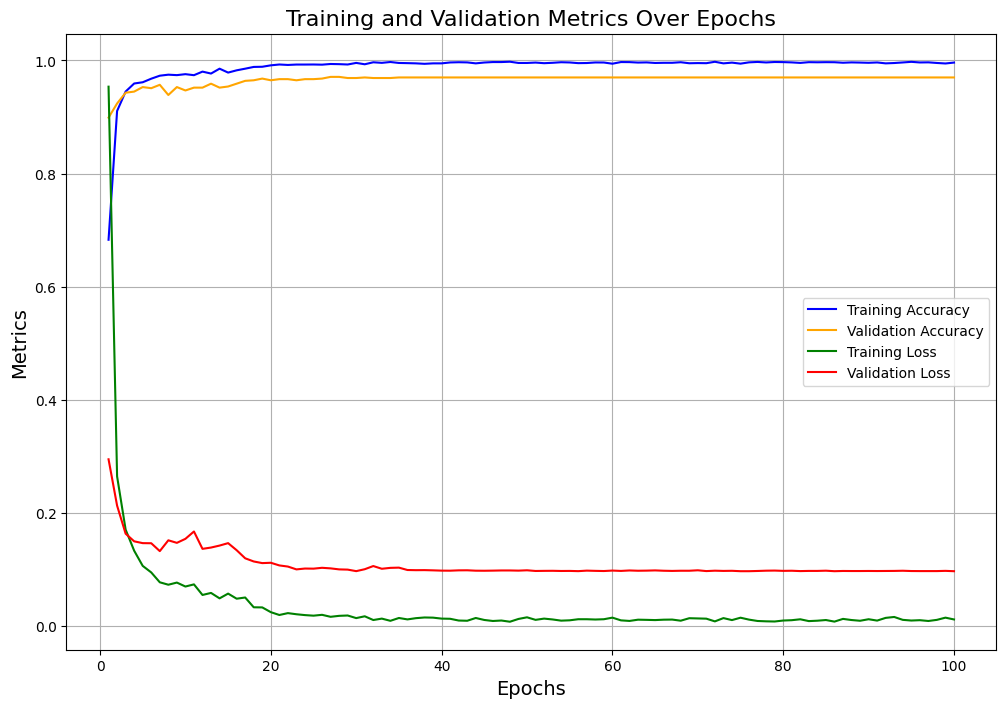

In [ ]:
import matplotlib.pyplot as plt

# Dữ liệu từ đoạn text
epochs = list(range(1, len(accuracy) + 1))

# Vẽ biểu đồ
plt.figure(figsize=(12, 8))

plt.plot(epochs, accuracy, label="Training Accuracy", color='blue', linestyle='-', marker='')
plt.plot(epochs, val_accuracy, label="Validation Accuracy", color='orange', linestyle='-', marker='')
plt.plot(epochs, loss, label="Training Loss", color='green', linestyle='-', marker='')
plt.plot(epochs, val_loss, label="Validation Loss", color='red', linestyle='-', marker='')

# Thêm nhãn và tiêu đề
plt.title("Training and Validation Metrics Over Epochs", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Metrics", fontsize=14)
plt.legend(loc='best')
plt.grid(True)

# Hiển thị biểu đồ
plt.show()


In [16]:
evaluation = model.evaluate(val_data)

# Print the evaluation metrics
print("Validation Loss:", evaluation[0])
print("Validation Accuracy:", evaluation[1])

32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - accuracy: 0.9532 - loss: 0.1506
Validation Loss: 0.12804493308067322
Validation Accuracy: 0.9549999833106995


In [1]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load mô hình đã lưu
model_path = "/content/drive/MyDrive/project1_genAI/checkpoint/ckpt_epoch_29.weights.h5"
model.load_weights(model_path)

# 2. Lấy tập dữ liệu validation
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    directory='/content/drive/MyDrive/project1_genAI/data/val',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),  # Đảm bảo khớp với kích thước ảnh đã sử dụng khi huấn luyện
    batch_size=32
)

# 3. Lấy danh sách tên nhãn
class_names = val_data.class_names  # Tên các lớp
print(class_names)
val_data = val_data.map(lambda x, y: (x / 255.0, y))  # Chuẩn hóa giá trị pixel

# 4. Khởi tạo các danh sách để lưu kết quả
true_labels_list = []
predicted_labels_list = []

# 5. Dự đoán và lưu kết quả
for images, labels in val_data:
    # Chuyển nhãn thực tế từ one-hot encoding thành chỉ số nhãn
    true_labels = np.argmax(labels.numpy(), axis=1)
    true_labels_list.extend(true_labels)

    # Dự đoán từ mô hình
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    predicted_labels_list.extend(predicted_labels)

# 6. Tính toán các metrics phân loại
accuracy = accuracy_score(true_labels_list, predicted_labels_list)
print(f"Accuracy: {accuracy * 100:.2f}%")

# 7. Vẽ confusion matrix
cm = confusion_matrix(true_labels_list, predicted_labels_list)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 8. In ra classification report (precision, recall, F1-score)
report = classification_report(true_labels_list, predicted_labels_list, target_names=class_names)
print("Classification Report:")
print(report)


NameError: name 'model' is not defined